##### Since evaluating the collocation constraints in the Gauss-Lobatto method requires two evaluations of the ODE, it typically suffers greater slowdown that the Radau Pseudospectral method, which evaluates the defects of the ODE with a single evaluation that encompasses all the nodes. For these reasons the Radau Pseudospectral transcription is typically preferable when using a differential inclusion approach to problems.

In [1]:
import matplotlib.pyplot as plt

import openmdao.api as om
import dymos as dm

from dymos.examples.aircraft_steady_flight.aircraft_ode import AircraftODE
from dymos.examples.plotting import plot_results
from dymos.utils.lgl import lgl

p = om.Problem(model=om.Group())
p.driver = om.pyOptSparseDriver()
p.driver.options['optimizer'] = 'IPOPT'
p.driver.opt_settings['print_level'] = 0
p.driver.declare_coloring()

num_seg = 15
seg_ends, _ = lgl(num_seg + 1)

traj = p.model.add_subsystem('traj', dm.Trajectory())

phase = traj.add_phase('phase0',
                       dm.Phase(ode_class=AircraftODE,
                                transcription=dm.Radau(num_segments=num_seg,
                                                       segment_ends=seg_ends,
                                                       order=3, compressed=False)))

# Pass Reference Area from an external source
assumptions = p.model.add_subsystem('assumptions', om.IndepVarComp())
assumptions.add_output('S', val=427.8, units='m**2')
assumptions.add_output('mass_empty', val=1.0, units='kg')
assumptions.add_output('mass_payload', val=1.0, units='kg')

phase.set_time_options(fix_initial=True,
                       duration_bounds=(300, 10000),
                       duration_ref=1000)

phase.add_state('range', units='NM',
                rate_source='range_rate_comp.dXdt:range',
                fix_initial=True, fix_final=False, ref=1e-3,
                defect_ref=1e-3, lower=0, upper=2000)

phase.add_state('mass_fuel', units='lbm',
                rate_source='propulsion.dXdt:mass_fuel',
                fix_initial=True, fix_final=True,
                upper=1.5E5, lower=0.0, ref=1e2, defect_ref=1e2)

phase.add_state('alt', units='kft',
                rate_source='climb_rate',
                fix_initial=True, fix_final=True,
                lower=0.0, upper=60, ref=1e-3, defect_ref=1e-3)

phase.add_control('climb_rate', units='ft/min', opt=True, lower=-3000, upper=3000,
                  targets=['gam_comp.climb_rate'],
                  rate_continuity=True, rate2_continuity=False)

phase.add_control('mach', targets=['tas_comp.mach', 'aero.mach'], units=None, opt=False)

phase.add_parameter('S',
                    targets=['aero.S', 'flight_equilibrium.S', 'propulsion.S'],
                    units='m**2')

phase.add_parameter('mass_empty', targets=['mass_comp.mass_empty'], units='kg')
phase.add_parameter('mass_payload', targets=['mass_comp.mass_payload'], units='kg')

phase.add_path_constraint('propulsion.tau', lower=0.01, upper=2.0)

p.model.connect('assumptions.S', 'traj.phase0.parameters:S')
p.model.connect('assumptions.mass_empty', 'traj.phase0.parameters:mass_empty')
p.model.connect('assumptions.mass_payload', 'traj.phase0.parameters:mass_payload')

phase.add_objective('range', loc='final', ref=-1.0)

phase.add_timeseries_output('aero.CL')
phase.add_timeseries_output('aero.CD')

p.setup()


--- Constraint Report [traj] ---
    --- phase0 ---
        [path]    1.0000e-02 <= propulsion.tau <= 2.0000e+00  [None]



In [2]:
p['traj.phase0.t_initial'] = 0.0
p['traj.phase0.t_duration'] = 3600.0
p['traj.phase0.states:range'] = phase.interp('range', ys=(0, 724.0))
p['traj.phase0.states:mass_fuel'] = phase.interp('mass_fuel', ys=(30000, 1e-3))
p['traj.phase0.states:alt'][:] = 10.0

p['traj.phase0.controls:mach'][:] = 0.8

p['assumptions.S'] = 427.8
p['assumptions.mass_empty'] = 0.15E6
p['assumptions.mass_payload'] = 84.02869 * 400

In [3]:
dm.run_problem(p, simulate=True, make_plots=True)

Model viewer data has already been recorded for Driver.
Full total jacobian was computed 3 times, taking 0.683371 seconds.
Total jacobian shape: (224, 221) 


Jacobian shape: (224, 221)  ( 2.90% nonzero)
FWD solves: 12   REV solves: 0
Total colors vs. total size: 12 vs 221  (94.6% improvement)

Sparsity computed using tolerance: 1e-25
Time to compute sparsity: 0.683371 sec.
Time to compute coloring: 0.130678 sec.
Memory to compute coloring: 0.375000 MB.


Optimization Problem -- Optimization using pyOpt_sparse
    Objective Function: _objfunc

    Solution: 
--------------------------------------------------------------------------------
    Total Time:                   21.5232
       User Objective Time :      19.1907
       User Sensitivity Time :     1.6695
       Interface Time :            0.1513
       Opt Solver Time:            0.5118
    Calls to Objective Function :      32
    Calls to Sens Function :           32


   Objectives
      Index  Name                           

/Users/h1he2li3/opt/anaconda3/envs/dymos_rangemax/lib/python3.11/site-packages/openmdao/visualization/opt_report/opt_report.py:634: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([ymin_plot, ymax_plot])



Simulating trajectory traj
Done simulating trajectory traj


False

In [5]:
 conda install -c conda-forge matplotlib

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.0
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



## Package Plan ##

  environment location: /Users/h1he2li3/opt/anaconda3/envs/dymos_rangemax

  added / updated specs:
    - matplotlib


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2023.5.7           |     pyhd8ed1ab_0         149 KB  conda-forge
    fonttools-4.39.4           |  py311h2725bcf_0         2.5 MB  conda-forge
    libxcb-1.15                |       hb7f2c08_0         306 KB  conda-forge
    llvm-openmp-16.0.4         |       hff08bdf_0         289 KB  conda-forge
    numpy-1.24.3               |  py311hc44ba51_0         7.1 MB  conda-forge
    pillow-9.

In [11]:
conda install -c conda-forge pyoptsparse

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.3.0
  latest version: 23.5.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=23.5.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [12]:
pip list

Package                       Version
----------------------------- --------
appnope                       0.1.3
asttokens                     2.2.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
certifi                       2023.5.7
charset-normalizer            3.1.0
comm                          0.1.3
contourpy                     1.0.7
cycler                        0.11.0
debugpy                       1.6.7
decorator                     5.1.1
dymos                         1.8.0
executing                     1.2.0
fonttools                     4.39.4
idna                          3.4
importlib-metadata            6.6.0
ipykernel                     6.23.1
ipython                       8.13.2
jedi                          0.18.2
jupyter_client                8.2.0
jupyter_core                  5.3.0
kiwisolver                    1.4.4
matplotlib                    3.7.1
matplotlib-inline             0.1.6
mdolab-baseclasses            1.7.0
munkres          

In [4]:
from IPython.display import Image
Image(p.get_reports_dir() / 'plots/states_alt.png', width=600)


FileNotFoundError: No such file or directory: 'reports/problem/plots/states_alt.png'

FileNotFoundError: No such file or directory: 'reports/problem/plots/states_alt.png'

<IPython.core.display.Image object>

In [5]:
Image(p.get_reports_dir() / 'plots/states_mass_fuel.png', width=600)

FileNotFoundError: No such file or directory: 'reports/problem/plots/states_mass_fuel.png'

FileNotFoundError: No such file or directory: 'reports/problem/plots/states_mass_fuel.png'

<IPython.core.display.Image object>

In [3]:
import openmdao.api as om
import dymos as dm
import numpy as np

class BatteryModel(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('I', val=np.ones(nn), desc='current', units='A')
        self.add_input('t', val=np.ones(nn), desc='time', units='s')
        self.add_output('Q', val=np.ones(nn), desc='charge', units='A*s')

    def compute(self, inputs, outputs):
        I = inputs['I']
        t = inputs['t']
        outputs['Q'] = I * t


p = om.Problem(model=om.Group())

traj = dm.Trajectory()
p.model.add_subsystem('traj', traj)

transcription = dm.GaussLobatto(num_segments=10)
phase = dm.Phase(ode_class=BatteryModel, transcription=transcription)

traj.add_phase('phase0', phase)

phase.set_time_options(fix_initial=True, duration_bounds=(0.5, 10.0))

phase.add_state('Q', rate_source='Q', targets=['Q'], units='A*s')

phase.add_control('I', targets=['I'], units='A')

phase.add_objective('time', loc='final')

p.setup()

p.set_val('traj.phase0.t_duration', 1.0)
p.set_val('traj.phase0.states:Q', phase.interp('Q', [0, 1]))
p.set_val('traj.phase0.controls:I', phase.interp('I', [1, 1]))

dm.run_problem(p)


RuntimeError: Error during configure_states_introspection in phase traj.phases.phase0.

In [5]:
import openmdao.api as om
import dymos as dm
import numpy as np

class BatteryModel(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('I', val=np.ones(nn), desc='current', units='A')
        self.add_output('Qdot', val=np.ones(nn), desc='charge rate', units='A*s/s')

    def compute(self, inputs, outputs):
        I = inputs['I']
        outputs['Qdot'] = I

p = om.Problem(model=om.Group())

traj = dm.Trajectory()
p.model.add_subsystem('traj', traj)

transcription = dm.GaussLobatto(num_segments=10)
phase = dm.Phase(ode_class=BatteryModel, transcription=transcription)

traj.add_phase('phase0', phase)

phase.set_time_options(fix_initial=True, duration_bounds=(0.5, 10.0))

phase.add_state('Q', rate_source='Qdot', targets=None, units='A*s')

phase.add_control('I', targets=['I'], units='A')

phase.add_objective('time', loc='final')

p.driver = om.ScipyOptimizeDriver()
p.setup()

p.set_val('traj.phase0.t_duration', 1.0)
p.set_val('traj.phase0.states:Q', phase.interp('Q', [0, 1]))
p.set_val('traj.phase0.controls:I', phase.interp('I', [1, 1]))

dm.run_problem(p)



--- Constraint Report [traj] ---
    --- phase0 ---
        None

Model viewer data has already been recorded for Driver.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5000000000000022
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization Complete
-----------------------------------


False

In [6]:
final_time = p.get_val('traj.phase0.t_duration')
final_charge = p.get_val('traj.phase0.states:Q')[-1]  # get the last value
final_current = p.get_val('traj.phase0.controls:I')[-1]  # get the last value

print(f"Final time: {final_time}")
print(f"Final charge: {final_charge}")
print(f"Final current: {final_current}")


Final time: [0.5]
Final charge: [0.75]
Final current: [1.]


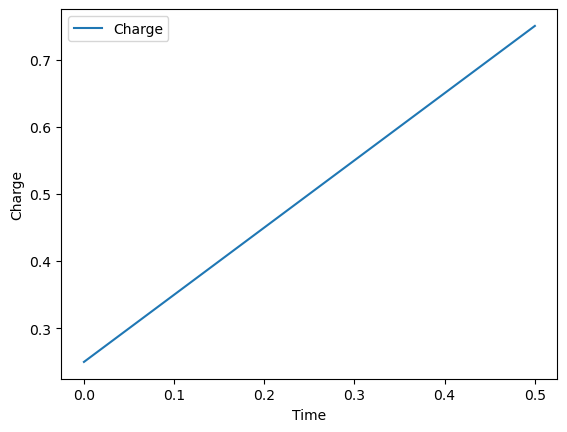

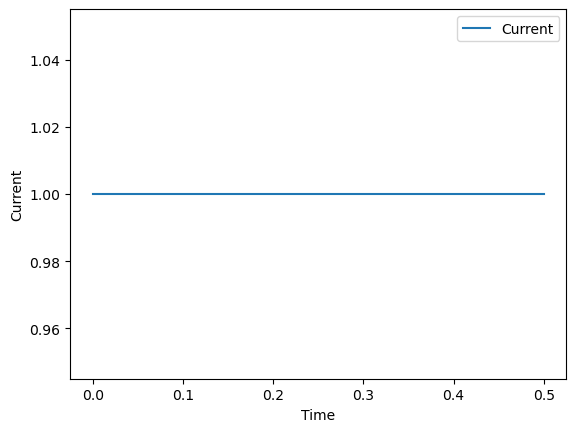

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

time = p.get_val('traj.phase0.timeseries.time')
charge = p.get_val('traj.phase0.timeseries.states:Q')
current = p.get_val('traj.phase0.timeseries.controls:I')

plt.figure()
plt.plot(time, charge, label='Charge')
plt.xlabel('Time')
plt.ylabel('Charge')
plt.legend()

plt.figure()
plt.plot(time, current, label='Current')
plt.xlabel('Time')
plt.ylabel('Current')
plt.legend()

plt.show()


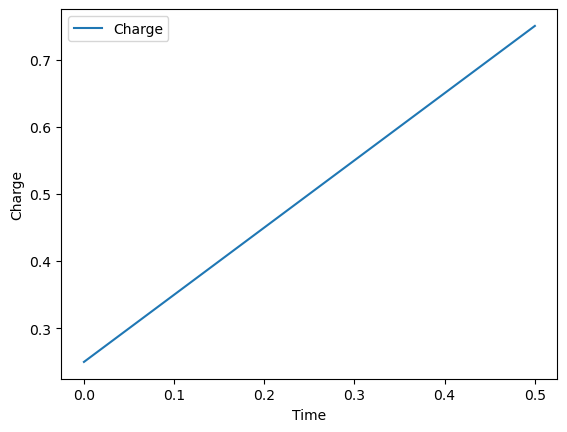

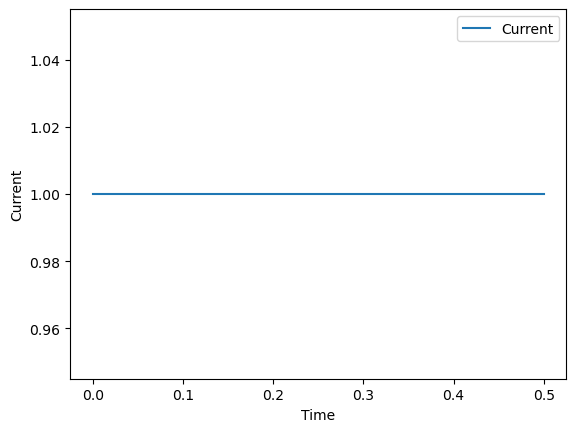

In [9]:
import matplotlib.pyplot as plt

time = p.get_val('traj.phase0.timeseries.time')
charge = p.get_val('traj.phase0.timeseries.states:Q')
current = p.get_val('traj.phase0.timeseries.controls:I')

plt.figure()
plt.plot(time, charge, label='Charge')
plt.xlabel('Time')
plt.ylabel('Charge')
plt.legend()

plt.figure()
plt.plot(time, current, label='Current')
plt.xlabel('Time')
plt.ylabel('Current')
plt.legend()

plt.show()


In [10]:
import openmdao.api as om
import dymos as dm
import numpy as np

class BatteryModel(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('I', val=np.ones(nn), desc='current', units='A')
        self.add_output('Qdot', val=np.ones(nn), desc='charge rate', units='A*s/s')

    def compute(self, inputs, outputs):
        I = inputs['I']
        outputs['Qdot'] = I

p = om.Problem(model=om.Group())

traj = dm.Trajectory()
p.model.add_subsystem('traj', traj)

transcription = dm.GaussLobatto(num_segments=10)
phase = dm.Phase(ode_class=BatteryModel, transcription=transcription)

traj.add_phase('phase0', phase)

phase.set_time_options(fix_initial=True, duration_bounds=(0.5, 10.0))

phase.add_state('Q', rate_source='Qdot', targets=None, units='A*s')

phase.add_control('I', targets=['I'], units='A')

phase.add_objective('time', loc='final')

p.driver = om.ScipyOptimizeDriver()

p.setup()

p.set_val('traj.phase0.t_duration', 1.0)
p.set_val('traj.phase0.states:Q', phase.interp('Q', [0, 1]))
p.set_val('traj.phase0.controls:I', phase.interp('I', [1, 1]))

dm.run_problem(p)



--- Constraint Report [traj] ---
    --- phase0 ---
        None

Model viewer data has already been recorded for Driver.
Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.5000000000000022
            Iterations: 3
            Function evaluations: 3
            Gradient evaluations: 3
Optimization Complete
-----------------------------------


False

In [11]:
import openmdao.api as om
import dymos as dm
import numpy as np

class BatteryModel(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('I', val=np.ones(nn), desc='current', units='A')
        self.add_input('load', val=np.ones(nn), desc='load', units='A')
        self.add_output('Qdot', val=np.ones(nn), desc='charge rate', units='A*s/s')
        self.add_output('weight', val=np.ones(nn), desc='weight', units='kg')

    def compute(self, inputs, outputs):
        I = inputs['I']
        load = inputs['load']
        outputs['Qdot'] = I - load  # charge rate is input current minus load
        outputs['weight'] = outputs['Qdot'] * 0.1  # weight is proportional to charge rate

p = om.Problem(model=om.Group())

traj = dm.Trajectory()
p.model.add_subsystem('traj', traj)

transcription = dm.GaussLobatto(num_segments=10)
phase = dm.Phase(ode_class=BatteryModel, transcription=transcription)

traj.add_phase('phase0', phase)

phase.set_time_options(fix_initial=True, duration_bounds=(0.5, 10.0))

phase.add_state('Q', rate_source='Qdot', targets=None, units='A*s')

phase.add_control('I', targets=['I'], units='A')

phase.add_parameter('load', targets=['load'], units='A')

phase.add_objective('traj.phase0.timeseries.weight', loc='final')

p.driver = om.ScipyOptimizeDriver()

p.setup()

p.set_val('traj.phase0.t_duration', 1.0)
p.set_val('traj.phase0.states:Q', phase.interp('Q', [0, 1]))
p.set_val('traj.phase0.controls:I', phase.interp('I', [1, 1]))
p.set_val('traj.phase0.parameters:load', phase.interp('load', [1, 1]))

dm.run_problem(p)


ValueError: Unable to find the source 'traj.phase0.timeseries.weight' in the ODE.

In [12]:
import openmdao.api as om
import dymos as dm
import numpy as np

class BatteryModel(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('I', val=np.ones(nn), desc='current', units='A')
        self.add_input('load', val=np.ones(nn), desc='load', units='A')
        self.add_output('Qdot', val=np.ones(nn), desc='charge rate', units='A*s/s')
        self.add_output('weight', val=np.ones(nn), desc='weight', units='kg')

    def compute(self, inputs, outputs):
        I = inputs['I']
        load = inputs['load']
        outputs['Qdot'] = I - load  # charge rate is input current minus load
        outputs['weight'] = outputs['Qdot'] * 0.1  # weight is proportional to charge rate

p = om.Problem(model=om.Group())

traj = dm.Trajectory()
p.model.add_subsystem('traj', traj)

transcription = dm.GaussLobatto(num_segments=10)
phase = dm.Phase(ode_class=BatteryModel, transcription=transcription)

traj.add_phase('phase0', phase)

phase.set_time_options(fix_initial=True, duration_bounds=(0.5, 10.0))

phase.add_state('Q', rate_source='Qdot', targets=None, units='A*s')
phase.add_state('weight', rate_source='0', targets=['weight'], units='kg')

phase.add_control('I', targets=['I'], units='A')

phase.add_parameter('load', targets=['load'], units='A')

phase.add_objective('weight', loc='final')

p.driver = om.ScipyOptimizeDriver()

p.setup()

p.set_val('traj.phase0.t_duration', 1.0)
p.set_val('traj.phase0.states:Q', phase.interp('Q', [0, 1]))
p.set_val('traj.phase0.states:weight', phase.interp('weight', [0, 1]))
p.set_val('traj.phase0.controls:I', phase.interp('I', [1, 1]))
p.set_val('traj.phase0.parameters:load', phase.interp('load', [1, 1]))

dm.run_problem(p)


RuntimeError: Error during configure_states_introspection in phase traj.phases.phase0.

In [13]:
import openmdao.api as om
import dymos as dm
import numpy as np

class BatteryModel(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('I', val=np.ones(nn), desc='current', units='A')
        self.add_input('load', val=np.ones(nn), desc='load', units='A')
        self.add_output('Qdot', val=np.ones(nn), desc='charge rate', units='A*s/s')

    def compute(self, inputs, outputs):
        I = inputs['I']
        load = inputs['load']
        outputs['Qdot'] = I - load  # charge rate is input current minus load

p = om.Problem(model=om.Group())

traj = dm.Trajectory()
p.model.add_subsystem('traj', traj)

transcription = dm.GaussLobatto(num_segments=10)
phase = dm.Phase(ode_class=BatteryModel, transcription=transcription)

traj.add_phase('phase0', phase)

phase.set_time_options(fix_initial=True, duration_bounds=(0.5, 10.0))

phase.add_state('Q', rate_source='Qdot', targets=None, units='A*s')

phase.add_control('I', targets=['I'], units='A')

phase.add_parameter('load', targets=['load'], units='A')

p.driver = om.ScipyOptimizeDriver()

p.setup()

p.set_val('traj.phase0.t_duration', 1.0)
p.set_val('traj.phase0.states:Q', phase.interp('Q', [0, 1]))
p.set_val('traj.phase0.controls:I', phase.interp('I', [1, 1]))
p.set_val('traj.phase0.parameters:load', phase.interp('load', [1, 1]))

dm.run_problem(p)

# Post-process to calculate the final weight
final_charge = p.get_val('traj.phase0.states:Q')[-1]  # get the last value
final_weight = final_charge * 0.1  # weight is proportional to charge
print(f"Final weight: {final_weight}")



--- Constraint Report [traj] ---
    --- phase0 ---
        None



ValueError: Could not find a state, control, or polynomial control named load to be interpolated.
Please explicitly specified the node subset onto which this value should be interpolated.

In [14]:
import openmdao.api as om
import dymos as dm
import numpy as np

class BatteryModel(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('I', val=np.ones(nn), desc='current', units='A')
        self.add_input('load', val=np.ones(nn), desc='load', units='A')
        self.add_output('Qdot', val=np.ones(nn), desc='charge rate', units='A*s/s')

    def compute(self, inputs, outputs):
        I = inputs['I']
        load = inputs['load']
        outputs['Qdot'] = I - load  # charge rate is input current minus load

p = om.Problem(model=om.Group())

traj = dm.Trajectory()
p.model.add_subsystem('traj', traj)

transcription = dm.GaussLobatto(num_segments=10)
phase = dm.Phase(ode_class=BatteryModel, transcription=transcription)

traj.add_phase('phase0', phase)

phase.set_time_options(fix_initial=True, duration_bounds=(0.5, 10.0))

phase.add_state('Q', rate_source='Qdot', targets=None, units='A*s')

phase.add_control('I', targets=['I'], units='A')

phase.add_parameter('load', targets=['load'], units='A')

p.driver = om.ScipyOptimizeDriver()

p.setup()

p.set_val('traj.phase0.t_duration', 1.0)
p.set_val('traj.phase0.states:Q', phase.interp('Q', [0, 1]))
p.set_val('traj.phase0.controls:I', phase.interp('I', [1, 1]))
p.set_val('traj.phase0.parameters:load', 1.0)  # set the value of the 'load' parameter directly

dm.run_problem(p)

# Post-process to calculate the final weight
final_charge = p.get_val('traj.phase0.states:Q')[-1]  # get the last value
final_weight = final_charge * 0.1  # weight is proportional to charge
print(f"Final weight: {final_weight}")



--- Constraint Report [traj] ---
    --- phase0 ---
        None

Model viewer data has already been recorded for Driver.


RuntimeError: Driver requires objective to be declared

In [15]:
import openmdao.api as om
import dymos as dm
import numpy as np

class BatteryModel(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('I', val=np.ones(nn), desc='current', units='A')
        self.add_input('load', val=np.ones(nn), desc='load', units='A')
        self.add_output('Qdot', val=np.ones(nn), desc='charge rate', units='A*s/s')

    def compute(self, inputs, outputs):
        I = inputs['I']
        load = inputs['load']
        outputs['Qdot'] = I - load  # charge rate is input current minus load

p = om.Problem(model=om.Group())

traj = dm.Trajectory()
p.model.add_subsystem('traj', traj)

transcription = dm.GaussLobatto(num_segments=10)
phase = dm.Phase(ode_class=BatteryModel, transcription=transcription)

traj.add_phase('phase0', phase)

phase.set_time_options(fix_initial=True, duration_bounds=(0.5, 10.0))

phase.add_state('Q', rate_source='Qdot', targets=None, units='A*s')

phase.add_control('I', targets=['I'], units='A')

phase.add_parameter('load', targets=['load'], units='A')

phase.add_objective('Q', loc='final')  # minimize the final charge

p.driver = om.ScipyOptimizeDriver()

p.setup()

p.set_val('traj.phase0.t_duration', 1.0)
p.set_val('traj.phase0.states:Q', phase.interp('Q', [0, 1]))
p.set_val('traj.phase0.controls:I', phase.interp('I', [1, 1]))
p.set_val('traj.phase0.parameters:load', 1.0)  # set the value of the 'load' parameter directly

dm.run_problem(p)

# Post-process to calculate the final weight
final_charge = p.get_val('traj.phase0.states:Q')[-1]  # get the last value
final_weight = final_charge * 0.1  # weight is proportional to charge
print(f"Final weight: {final_weight}")



--- Constraint Report [traj] ---
    --- phase0 ---
        None

Model viewer data has already been recorded for Driver.


/Users/h1he2li3/opt/anaconda3/envs/dymos_rangemax/lib/python3.11/site-packages/openmdao/core/total_jac.py:1665: DerivativesWarning:Design variables [('traj.phases.phase0.time_extents.t_duration', inds=[0])] have no impact on the constraints or objective.


Inequality constraints incompatible    (Exit mode 4)
            Current function value: -5.635760304345062e+20
            Iterations: 34
            Function evaluations: 34
            Gradient evaluations: 34
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Final weight: [-5.6357603e+19]


In [16]:
import openmdao.api as om
import dymos as dm
import numpy as np

class BatteryModel(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('I', val=np.ones(nn), desc='current', units='A')
        self.add_input('load', val=np.ones(nn), desc='load', units='A')
        self.add_output('Qdot', val=np.ones(nn), desc='charge rate', units='A*s/s')

    def compute(self, inputs, outputs):
        I = inputs['I']
        load = inputs['load']
        outputs['Qdot'] = I - load  # charge rate is input current minus load

p = om.Problem(model=om.Group())

traj = dm.Trajectory()
p.model.add_subsystem('traj', traj)

transcription = dm.GaussLobatto(num_segments=10)
phase = dm.Phase(ode_class=BatteryModel, transcription=transcription)

traj.add_phase('phase0', phase)

phase.set_time_options(fix_initial=True, duration_bounds=(0.5, 10.0))

phase.add_state('Q', rate_source='Qdot', targets=None, units='A*s')

phase.add_control('I', targets=['I'], units='A', lower=-10.0, upper=10.0)  # allow 'I' to be negative

phase.add_parameter('load', targets=['load'], units='A')

phase.add_objective('Q', loc='final')  # minimize the final charge

p.driver = om.ScipyOptimizeDriver()

p.setup()

p.set_val('traj.phase0.t_duration', 1.0)
p.set_val('traj.phase0.states:Q', phase.interp('Q', [0, 1]))
p.set_val('traj.phase0.controls:I', phase.interp('I', [1, 1]))
p.set_val('traj.phase0.parameters:load', 1.0)  # set the value of the 'load' parameter directly

dm.run_problem(p)

# Post-process to calculate the final weight
final_charge = p.get_val('traj.phase0.states:Q')[-1]  # get the last value
final_weight = final_charge * 0.1  # weight is proportional to charge
print(f"Final weight: {final_weight}")




--- Constraint Report [traj] ---
    --- phase0 ---
        None

Model viewer data has already been recorded for Driver.


/Users/h1he2li3/opt/anaconda3/envs/dymos_rangemax/lib/python3.11/site-packages/openmdao/core/total_jac.py:1665: DerivativesWarning:Design variables [('traj.phases.phase0.time_extents.t_duration', inds=[0])] have no impact on the constraints or objective.


Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1.1269339059382154e+20
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Final weight: [-1.12693391e+19]


In [17]:
import openmdao.api as om
import dymos as dm
import numpy as np

class BatteryModel(om.ExplicitComponent):
    def initialize(self):
        self.options.declare('num_nodes', types=int)

    def setup(self):
        nn = self.options['num_nodes']
        self.add_input('I', val=np.ones(nn), desc='current', units='A')
        self.add_input('load', val=np.ones(nn), desc='load', units='A')
        self.add_output('Qdot', val=np.ones(nn), desc='charge rate', units='A*s/s')

    def compute(self, inputs, outputs):
        I = inputs['I']
        load = inputs['load']
        outputs['Qdot'] = I - load  # charge rate is input current minus load

p = om.Problem(model=om.Group())

traj = dm.Trajectory()
p.model.add_subsystem('traj', traj)

transcription = dm.GaussLobatto(num_segments=10)
phase = dm.Phase(ode_class=BatteryModel, transcription=transcription)

traj.add_phase('phase0', phase)

phase.set_time_options(fix_initial=True, duration_bounds=(0.5, 10.0))

phase.add_state('Q', rate_source='Qdot', targets=None, units='A*s')

phase.add_control('I', targets=['I'], units='A', lower=-10.0, upper=10.0)  # allow 'I' to be negative

phase.add_parameter('load', targets=['load'], units='A')

phase.add_objective('Q', loc='final')  # minimize the final charge

p.driver = om.ScipyOptimizeDriver()

p.setup()

p.set_val('traj.phase0.t_duration', 1.0)
p.set_val('traj.phase0.states:Q', phase.interp('Q', [0, 1]))
p.set_val('traj.phase0.controls:I', phase.interp('I', [1, 1]))
p.set_val('traj.phase0.parameters:load', 1.0)  # set the value of the 'load' parameter directly

dm.run_problem(p)

# Post-process to calculate the final weight
final_charge = p.get_val('traj.phase0.states:Q')[-1]  # get the last value
final_weight = final_charge * 0.1  # weight is proportional to charge
print(f"Final weight: {final_weight}")



--- Constraint Report [traj] ---
    --- phase0 ---
        None

Model viewer data has already been recorded for Driver.


/Users/h1he2li3/opt/anaconda3/envs/dymos_rangemax/lib/python3.11/site-packages/openmdao/core/total_jac.py:1665: DerivativesWarning:Design variables [('traj.phases.phase0.time_extents.t_duration', inds=[0])] have no impact on the constraints or objective.


Inequality constraints incompatible    (Exit mode 4)
            Current function value: -1.1269339059382154e+20
            Iterations: 33
            Function evaluations: 33
            Gradient evaluations: 33
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Final weight: [-1.12693391e+19]


In [18]:
import openmdao.api as om

class BatteryOptimization(om.ExplicitComponent):

    def setup(self):
        self.add_input('solar_power', shape=(7 * 24 * 60 * 60,))
        self.add_input('demand', shape=(7 * 24 * 60 * 60,))
        self.add_output('battery_capacity')

    def compute(self, inputs, outputs):
        solar_power = inputs['solar_power']
        demand = inputs['demand']
        battery_capacity = outputs['battery_capacity']

        # Battery capacity is the optimization variable to minimize
        battery_capacity = om.IndepVarComp('battery_capacity', val=1.0)  # Initial guess for battery capacity

        # Constraints
        constraints = om.Group()
        constraints.add_subsystem('charge_constraint', ChargeConstraint())
        constraints.add_subsystem('backup_constraint', BackupConstraint())

        # Objective function
        objective = om.Minimize('battery_capacity')

        # Define the problem
        prob = om.Problem()
        prob.model.add_subsystem('battery_capacity', battery_capacity)
        prob.model.add_subsystem('constraints', constraints)
        prob.model.add_objective(objective)

        # Set up the problem
        prob.setup()

        # Set the values of the inputs
        prob['solar_power'] = solar_power
        prob['demand'] = demand

        # Solve the problem
        prob.run_driver()

        # Retrieve the optimized battery capacity
        battery_capacity_optimized = prob['battery_capacity']

        # Store the optimized battery capacity in the outputs
        outputs['battery_capacity'] = battery_capacity_optimized


class ChargeConstraint(om.ExplicitComponent):

    def setup(self):
        self.add_input('solar_power', shape=(7 * 24 * 60 * 60,))
        self.add_input('demand', shape=(7 * 24 * 60 * 60,))
        self.add_input('battery_capacity')
        self.add_output('charge_constraint')

    def compute(self, inputs, outputs):
        solar_power = inputs['solar_power']
        demand = inputs['demand']
        battery_capacity = inputs['battery_capacity']
        charge_constraint = outputs['charge_constraint']

        # Implement the charge constraint logic based on solar power, demand, and battery capacity
        # Charge constraint equation: If S(t) > D(t), then (S(t) - D(t)) / 3600 ≤ 5C

        outputs['charge_constraint'] = ...


class BackupConstraint(om.ExplicitComponent):

    def setup(self):
        self.add_input('battery_capacity')
        self.add_output('backup_constraint')

    def compute(self, inputs, outputs):
        battery_capacity = inputs['battery_capacity']
        backup_constraint = outputs['backup_constraint']

        # Implement the backup constraint logic based on battery capacity
        # Backup constraint equation: B(t) ≥ 0 for t = 4 * 24 * 60 * 60 to 7 * 24 * 60 * 60

        outputs['backup_constraint'] = ...


# Example usage
if __name__ == "__main__":
    prob = om.Problem()
    prob.model.add_subsystem('battery_optimization', BatteryOptimization())
    prob.setup()
    prob.run_model()

    # Retrieve the optimized battery capacity
    battery_capacity_optimized = prob['battery_optimization.battery_capacity']

    print("Optimized battery capacity:", battery_capacity_optimized)


AttributeError: 'battery_optimization' <class BatteryOptimization>: Error calling compute(), module 'openmdao.api' has no attribute 'Minimize'

In [19]:
import numpy as np
import openmdao.api as om

class BatteryOptimization(om.ExplicitComponent):

    def setup(self):
        self.add_input('solar_power', shape=(7 * 24 * 60 * 60,))
        self.add_input('demand', shape=(7 * 24 * 60 * 60,))
        self.add_output('battery_capacity')

    def compute(self, inputs, outputs):
        solar_power = inputs['solar_power']
        demand = inputs['demand']
        battery_capacity = outputs['battery_capacity']

        # Battery capacity is the optimization variable to minimize
        battery_capacity = om.IndepVarComp('battery_capacity', val=1.0)  # Initial guess for battery capacity

        # Constraints
        constraints = om.Group()
        constraints.add_subsystem('charge_constraint', ChargeConstraint())
        constraints.add_subsystem('backup_constraint', BackupConstraint())

        # Objective function
        objective = om.Objective('battery_capacity', scaler=-1.0)  # Minimize the battery capacity (negative objective)

        # Define the problem
        prob = om.Problem()
        prob.model.add_subsystem('battery_capacity', battery_capacity)
        prob.model.add_subsystem('constraints', constraints)
        prob.model.add_objective(objective)

        # Set up the problem
        prob.setup()

        # Set the values of the inputs
        prob.set_val('solar_power', solar_power)
        prob.set_val('demand', demand)

        # Solve the problem
        prob.run_driver()

        # Retrieve the optimized battery capacity
        battery_capacity_optimized = prob.get_val('battery_capacity')

        # Store the optimized battery capacity in the outputs
        outputs['battery_capacity'] = battery_capacity_optimized


class ChargeConstraint(om.ExplicitComponent):

    def setup(self):
        self.add_input('solar_power', shape=(7 * 24 * 60 * 60,))
        self.add_input('demand', shape=(7 * 24 * 60 * 60,))
        self.add_input('battery_capacity')
        self.add_output('charge_constraint')

    def compute(self, inputs, outputs):
        solar_power = inputs['solar_power']
        demand = inputs['demand']
        battery_capacity = inputs['battery_capacity']

        # Implement the charge constraint logic based on solar power, demand, and battery capacity
        # Charge constraint equation: If S(t) > D(t), then (S(t) - D(t)) / 3600 ≤ 5C
        excess_power = np.maximum(solar_power - demand, 0)
        charge_constraint = np.where(excess_power > 0, excess_power / 3600 - 5 * battery_capacity, 0)

        outputs['charge_constraint'] = charge_constraint


class BackupConstraint(om.ExplicitComponent):

    def setup(self):
        self.add_input('battery_capacity')
        self.add_output('backup_constraint')

    def compute(self, inputs, outputs):
        battery_capacity = inputs['battery_capacity']

        # Implement the backup constraint logic based on battery capacity
        # Backup constraint equation: B(t) ≥ 0 for t = 4 * 24 * 60 * 60 to 7 * 24 * 60 * 60
        backup_constraint = np.where(np.arange(7 * 24 * 60 * 60) >= 4 * 24 * 60 * 60, -battery_capacity, 0)

        outputs['backup_constraint'] = backup_constraint


# Example usage
if __name__ == "__main__":
    solar_profile = np.random.random((7 * 24 * 60 * 60,))
    demand_profile = np.random.random((7 * 24 * 60 * 60,))

    prob = om.Problem()
    prob.model.add_subsystem('battery_optimization', BatteryOptimization())
    prob.setup()

    prob.set_val('battery_optimization.solar_power', solar_profile)
    prob.set_val('battery_optimization.demand', demand_profile)

    prob.run_model()

    battery_capacity_optimized = prob.get_val('battery_optimization.battery_capacity')

    print("Optimized battery capacity:", battery_capacity_optimized)


AttributeError: 'battery_optimization' <class BatteryOptimization>: Error calling compute(), module 'openmdao.api' has no attribute 'Objective'

In [20]:
import numpy as np
import openmdao.api as om

class BatteryOptimization(om.ExplicitComponent):

    def setup(self):
        self.add_input('solar_power', shape=(7 * 24 * 60 * 60,))
        self.add_input('demand', shape=(7 * 24 * 60 * 60,))
        self.add_output('battery_capacity')

    def compute(self, inputs, outputs):
        solar_power = inputs['solar_power']
        demand = inputs['demand']
        battery_capacity = outputs['battery_capacity']

        # Battery capacity is the optimization variable to minimize
        battery_capacity = om.IndepVarComp('battery_capacity', val=1.0)  # Initial guess for battery capacity

        # Constraints
        constraints = om.Group()
        constraints.add_subsystem('charge_constraint', ChargeConstraint())
        constraints.add_subsystem('backup_constraint', BackupConstraint())

        # Objective function
        objective = om.ExecComp('obj = -battery_capacity', obj=np.zeros(1))

        # Define the problem
        prob = om.Problem()
        prob.model.add_subsystem('battery_capacity', battery_capacity)
        prob.model.add_subsystem('constraints', constraints)
        prob.model.add_subsystem('objective', objective)
        prob.model.connect('battery_capacity', 'objective.battery_capacity')

        # Set up the problem
        prob.setup()

        # Set the values of the inputs
        prob.set_val('solar_power', solar_power)
        prob.set_val('demand', demand)

        # Solve the problem
        prob.run_driver()

        # Retrieve the optimized battery capacity
        battery_capacity_optimized = prob.get_val('battery_capacity')

        # Store the optimized battery capacity in the outputs
        outputs['battery_capacity'] = battery_capacity_optimized


class ChargeConstraint(om.ExplicitComponent):

    def setup(self):
        self.add_input('solar_power', shape=(7 * 24 * 60 * 60,))
        self.add_input('demand', shape=(7 * 24 * 60 * 60,))
        self.add_input('battery_capacity')
        self.add_output('charge_constraint')

    def compute(self, inputs, outputs):
        solar_power = inputs['solar_power']
        demand = inputs['demand']
        battery_capacity = inputs['battery_capacity']

        # Implement the charge constraint logic based on solar power, demand, and battery capacity
        # Charge constraint equation: If S(t) > D(t), then (S(t) - D(t)) / 3600 ≤ 5C
        excess_power = np.maximum(solar_power - demand, 0)
        charge_constraint = np.where(excess_power > 0, excess_power / 3600 - 5 * battery_capacity, 0)

        outputs['charge_constraint'] = charge_constraint


class BackupConstraint(om.ExplicitComponent):

    def setup(self):
        self.add_input('battery_capacity')
        self.add_output('backup_constraint')

    def compute(self, inputs, outputs):
        battery_capacity = inputs['battery_capacity']

        # Implement the backup constraint logic based on battery capacity
        # Backup constraint equation: B(t) ≥ 0 for t = 4 * 24 * 60 * 60 to 7 * 24 * 60 * 60
        backup_constraint = np.where(np.arange(7 * 24 * 60 * 60) >= 4 * 24 * 60 * 60, -battery_capacity, 0)

        outputs['backup_constraint'] = backup_constraint


# Generate sample solar profile and demand profile
solar_profile = np.random.random((7 * 24 * 60 * 60,))
demand_profile = np.random.random((7 * 24 * 60 * 60,))

# Solve the battery optimization problem
prob = om.Problem()
prob.model.add_subsystem('battery_optimization', BatteryOptimization())
prob.setup()

prob.set_val('battery_optimization.solar_power', solar_profile)
prob.set_val('battery_optimization.demand', demand_profile)

prob.run_model()

battery_capacity_optimized = prob.get_val('battery_optimization.battery_capacity')

print("Optimized battery capacity:", battery_capacity_optimized)



RuntimeError: 'battery_optimization' <class BatteryOptimization>: Error calling compute(), 
Collected errors for problem 'problem17':
   <model> <class Group>: Attempted to connect from 'battery_capacity' to 'objective.battery_capacity', but 'battery_capacity' doesn't exist. Perhaps you meant to connect to one of the following outputs: ['battery_capacity.battery_capacity'].

In [21]:
import numpy as np
import openmdao.api as om

class BatteryOptimization(om.ExplicitComponent):

    def setup(self):
        self.add_input('solar_power', shape=(7 * 24 * 60 * 60,))
        self.add_input('demand', shape=(7 * 24 * 60 * 60,))
        self.add_output('battery_capacity')

    def compute(self, inputs, outputs):
        solar_power = inputs['solar_power']
        demand = inputs['demand']
        battery_capacity = outputs['battery_capacity']

        # Battery capacity is the optimization variable to minimize
        battery_capacity = om.IndepVarComp('battery_capacity', val=1.0)  # Initial guess for battery capacity

        # Constraints
        constraints = om.Group()
        constraints.add_subsystem('charge_constraint', ChargeConstraint())
        constraints.add_subsystem('backup_constraint', BackupConstraint())

        # Objective function
        objective = om.ExecComp('obj = -battery_capacity.battery_capacity', obj=np.zeros(1))

        # Define the problem
        prob = om.Problem()
        prob.model.add_subsystem('battery_capacity', battery_capacity)
        prob.model.add_subsystem('constraints', constraints)
        prob.model.add_subsystem('objective', objective)
        prob.model.connect('battery_capacity.battery_capacity', 'objective.battery_capacity')

        # Set up the problem
        prob.setup()

        # Set the values of the inputs
        prob.set_val('solar_power', solar_power)
        prob.set_val('demand', demand)

        # Solve the problem
        prob.run_driver()

        # Retrieve the optimized battery capacity
        battery_capacity_optimized = prob.get_val('battery_capacity.battery_capacity')

        # Store the optimized battery capacity in the outputs
        outputs['battery_capacity'] = battery_capacity_optimized


class ChargeConstraint(om.ExplicitComponent):

    def setup(self):
        self.add_input('solar_power', shape=(7 * 24 * 60 * 60,))
        self.add_input('demand', shape=(7 * 24 * 60 * 60,))
        self.add_input('battery_capacity')
        self.add_output('charge_constraint')

    def compute(self, inputs, outputs):
        solar_power = inputs['solar_power']
        demand = inputs['demand']
        battery_capacity = inputs['battery_capacity']

        # Implement the charge constraint logic based on solar power, demand, and battery capacity
        # Charge constraint equation: If S(t) > D(t), then (S(t) - D(t)) / 3600 ≤ 5C
        excess_power = np.maximum(solar_power - demand, 0)
        charge_constraint = np.where(excess_power > 0, excess_power / 3600 - 5 * battery_capacity, 0)

        outputs['charge_constraint'] = charge_constraint


class BackupConstraint(om.ExplicitComponent):

    def setup(self):
        self.add_input('battery_capacity')
        self.add_output('backup_constraint')

    def compute(self, inputs, outputs):
        battery_capacity = inputs['battery_capacity']

        # Implement the backup constraint logic based on battery capacity
        # Backup constraint equation: B(t) ≥ 0 for t = 4 * 24 * 60 * 60 to 7 * 24 * 60 * 60
        backup_constraint = np.where(np.arange(7 * 24 * 60 * 60) >= 4 * 24 * 60 * 60, -battery_capacity, 0)

        outputs['backup_constraint'] = backup_constraint


# Generate sample solar profile and demand profile
solar_profile = np.random.random((7 * 24 * 60 * 60,))
demand_profile = np.random.random((7 * 24 * 60 * 60,))

# Solve the battery optimization problem
prob = om.Problem()
prob.model.add_subsystem('battery_optimization', BatteryOptimization())
prob.setup()

prob.set_val('battery_optimization.solar_power', solar_profile)
prob.set_val('battery_optimization.demand', demand_profile)

prob.run_model()

battery_capacity_optimized = prob.get_val('battery_optimization.battery_capacity')

print("Optimized battery capacity:", battery_capacity_optimized)


KeyError: '\'battery_optimization\' <class BatteryOptimization>: Error calling compute(), \'<model> <class Group>: Variable "solar_power" not found.\''

In [22]:
import numpy as np
import openmdao.api as om

class BatteryOptimization(om.ExplicitComponent):

    def setup(self):
        self.add_input('solar_power', shape=(7 * 24 * 60 * 60,))
        self.add_input('demand', shape=(7 * 24 * 60 * 60,))
        self.add_output('battery_capacity')

    def compute(self, inputs, outputs):
        solar_power = inputs['solar_power']
        demand = inputs['demand']
        battery_capacity = outputs['battery_capacity']

        # Battery capacity is the optimization variable to minimize
        battery_capacity = om.IndepVarComp('battery_capacity', val=1.0)  # Initial guess for battery capacity

        # Constraints
        constraints = om.Group()
        constraints.add_subsystem('charge_constraint', ChargeConstraint())
        constraints.add_subsystem('backup_constraint', BackupConstraint())

        # Objective function
        objective = om.ExecComp('obj = -battery_capacity.battery_capacity', obj=np.zeros(1))

        # Define the problem
        prob = om.Problem()
        prob.model.add_subsystem('battery_capacity', battery_capacity)
        prob.model.add_subsystem('constraints', constraints)
        prob.model.add_subsystem('objective', objective)
        prob.model.connect('battery_capacity.battery_capacity', 'objective.battery_capacity')

        # Set up the problem
        prob.setup()

        # Set the values of the inputs
        prob.set_val('battery_optimization.solar_power', solar_power)
        prob.set_val('battery_optimization.demand', demand)

        # Solve the problem
        prob.run_model()

        # Retrieve the optimized battery capacity
        battery_capacity_optimized = prob.get_val('battery_optimization.battery_capacity')

        # Store the optimized battery capacity in the outputs
        outputs['battery_capacity'] = battery_capacity_optimized


class ChargeConstraint(om.ExplicitComponent):

    def setup(self):
        self.add_input('solar_power', shape=(7 * 24 * 60 * 60,))
        self.add_input('demand', shape=(7 * 24 * 60 * 60,))
        self.add_input('battery_capacity')
        self.add_output('charge_constraint')

    def compute(self, inputs, outputs):
        solar_power = inputs['solar_power']
        demand = inputs['demand']
        battery_capacity = inputs['battery_capacity']

        # Implement the charge constraint logic based on solar power, demand, and battery capacity
        # Charge constraint equation: If S(t) > D(t), then (S(t) - D(t)) / 3600 ≤ 5C
        excess_power = np.maximum(solar_power - demand, 0)
        charge_constraint = np.where(excess_power > 0, excess_power / 3600 - 5 * battery_capacity, 0)

        outputs['charge_constraint'] = charge_constraint


class BackupConstraint(om.ExplicitComponent):

    def setup(self):
        self.add_input('battery_capacity')
        self.add_output('backup_constraint')

    def compute(self, inputs, outputs):
        battery_capacity = inputs['battery_capacity']

        # Implement the backup constraint logic based on battery capacity
        # Backup constraint equation: B(t) ≥ 0 for t = 4 * 24 * 60 * 60 to 7 * 24 * 60 * 60
        backup_constraint = np.where(np.arange(7 * 24 * 60 * 60) >= 4 * 24 * 60 * 60, -battery_capacity, 0)

        outputs['backup_constraint'] = backup_constraint


# Generate sample solar profile and demand profile
solar_profile = np.random.random((7 * 24 * 60 * 60,))
demand_profile = np.random.random((7 * 24 * 60 * 60,))

# Solve the battery optimization problem
prob = om.Problem()
prob.model.add_subsystem('battery_optimization', BatteryOptimization())
prob.setup()

prob.set_val('battery_optimization.solar_power', solar_profile)
prob.set_val('battery_optimization.demand', demand_profile)

prob.run_model()

battery_capacity_optimized = prob.get_val('battery_optimization.battery_capacity')

print("Optimized battery capacity:", battery_capacity_optimized)



KeyError: '\'battery_optimization\' <class BatteryOptimization>: Error calling compute(), \'<model> <class Group>: Variable "battery_optimization.solar_power" not found.\''